<a href="https://colab.research.google.com/github/Kim-Ju-won/HUFS-Winter-AI-Reinforcement-Learning/blob/main/Day11/2_RL_BTN_trader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mplfinance

     |████████████████████████████████| 64 kB 1.3 MB/s 


In [2]:
from google.colab.patches import cv2_imshow
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
from datetime import datetime
import os
import cv2
import numpy as np

def Write_to_file(Date, net_worth, filename='{}.txt'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))):
    for i in net_worth: 
        Date += " {}".format(i)
    #print(Date)
    if not os.path.exists('logs'):
        os.makedirs('logs')
    file = open("logs/"+filename, 'a+')
    file.write(Date+"\n")
    file.close()

class TradingGraph:
    # A crypto trading visualization using matplotlib made to render custom prices which come in following way:
    # Date, Open, High, Low, Close, Volume, net_worth, trades
    # call render every step
    def __init__(self, Render_range):
        self.Volume = deque(maxlen=Render_range)
        self.net_worth = deque(maxlen=Render_range)
        self.render_data = deque(maxlen=Render_range)
        self.Render_range = Render_range

        # We are using the style ‘ggplot’
        plt.style.use('ggplot')
        # close all plots if there are open
        plt.close('all')
        # figsize attribute allows us to specify the width and height of a figure in unit inches
        self.fig = plt.figure(figsize=(16,8)) 

        # Create top subplot for price axis
        self.ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
        
        # Create bottom subplot for volume which shares its x-axis
        self.ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=self.ax1)
        
        # Create a new axis for net worth which shares its x-axis with price
        self.ax3 = self.ax1.twinx()

        # Formatting Date
        self.date_format = mpl_dates.DateFormatter('%d-%m-%Y')
        #self.date_format = mpl_dates.DateFormatter('%d-%m-%Y')
        
        # Add paddings to make graph easier to view
        #plt.subplots_adjust(left=0.07, bottom=-0.1, right=0.93, top=0.97, wspace=0, hspace=0)

    # Render the environment to the screen
    def render(self, Date, Open, High, Low, Close, Volume, net_worth, trades):
        # append volume and net_worth to deque list
        self.Volume.append(Volume)
        self.net_worth.append(net_worth)

        # before appending to deque list, need to convert Date to special format
        Date = mpl_dates.date2num([pd.to_datetime(Date)])[0]
        self.render_data.append([Date, Open, High, Low, Close])
        
        # Clear the frame rendered last step
        self.ax1.clear()
        candlestick_ohlc(self.ax1, self.render_data, width=0.8/24, colorup='green', colordown='red', alpha=0.8)

        # Put all dates to one list and fill ax2 sublot with volume
        Date_Render_range = [i[0] for i in self.render_data]
        self.ax2.clear()
        self.ax2.fill_between(Date_Render_range, self.Volume, 0)

        # draw our net_worth graph on ax3 (shared with ax1) subplot
        self.ax3.clear()
        self.ax3.plot(Date_Render_range, self.net_worth, color="blue")
        
        # beautify the x-labels (Our Date format)
        self.ax1.xaxis.set_major_formatter(self.date_format)
        self.fig.autofmt_xdate()

        # sort sell and buy orders, put arrows in appropiate order positions
        for trade in trades:
            trade_date = mpl_dates.date2num([pd.to_datetime(trade['Date'])])[0]
            if trade_date in Date_Render_range:
                if trade['type'] == 'buy':
                    high_low = trade['Low']-10
                    self.ax1.scatter(trade_date, high_low, c='green', label='green', s = 120, edgecolors='none', marker="^")
                else:
                    high_low = trade['High']+10
                    self.ax1.scatter(trade_date, high_low, c='red', label='red', s = 120, edgecolors='none', marker="v")

        # we need to set layers every step, because we are clearing subplots every step
        self.ax2.set_xlabel('Date')
        self.ax1.set_ylabel('Price')
        self.ax3.set_ylabel('Balance')

        # I use tight_layout to replace plt.subplots_adjust
        self.fig.tight_layout()

        """Display image with matplotlib - interrupting other tasks"""
        # Show the graph without blocking the rest of the program
        #plt.show(block=False)
        # Necessary to view frames before they are unrendered
        #plt.pause(0.001)

        """Display image with OpenCV - no interruption"""
        # redraw the canvas
        self.fig.canvas.draw()
        # convert canvas to image
        img = np.fromstring(self.fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img  = img.reshape(self.fig.canvas.get_width_height()[::-1] + (3,))

        # img is rgb, convert to opencv's default bgr
        image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # display image with OpenCV or any operation you like
        #cv2.imshow("Bitcoin trading bot",image)
        
        #save image
        imgfilename='images/{}.png'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
        cv2.imwrite(imgfilename, image)
        #cv2_imshow(image)

        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            return

In [3]:
import pandas as pd
import numpy as np
import random
from collections import deque

class CustomEnv:
    # A custom Bitcoin trading environment
    def __init__(self, df, initial_balance=1000, lookback_window_size=50, Render_range = 100):
        # Define action space and state size and other custom parameters
        self.df = df.dropna().reset_index()
        self.df_total_steps = len(self.df)-1
        self.initial_balance = initial_balance
        self.lookback_window_size = lookback_window_size
        self.Render_range = Render_range # render range in visualization

        # Action space from 0 to 3, 0 is hold, 1 is buy, 2 is sell
        self.action_space = np.array([0, 1, 2])

        # Orders history contains the balance, net_worth, crypto_bought, crypto_sold, crypto_held values for the last lookback_window_size steps
        self.orders_history = deque(maxlen=self.lookback_window_size)
        
        # Market history contains the OHCL values for the last lookback_window_size prices
        self.market_history = deque(maxlen=self.lookback_window_size)

        # State size contains Market+Orders history for the last lookback_window_size steps
        self.state_size = (self.lookback_window_size, 10)

    # Reset the state of the environment to an initial state
    def reset(self, env_steps_size = 0):
        self.visualization = TradingGraph(Render_range=self.Render_range) # init visualization
        self.trades = deque(maxlen=self.Render_range) # limited orders memory for visualization
        
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.prev_net_worth = self.initial_balance
        self.crypto_held = 0
        self.crypto_sold = 0
        self.crypto_bought = 0
        if env_steps_size > 0: # used for training dataset
            self.start_step = random.randint(self.lookback_window_size, self.df_total_steps - env_steps_size)
            self.end_step = self.start_step + env_steps_size
        else: # used for testing dataset
            self.start_step = self.lookback_window_size
            self.end_step = self.df_total_steps
            
        self.current_step = self.start_step

        for i in reversed(range(self.lookback_window_size)):
            current_step = self.current_step - i
            self.orders_history.append([self.balance, self.net_worth, self.crypto_bought, self.crypto_sold, self.crypto_held])
            self.market_history.append([self.df.loc[current_step, 'Open'],
                                        self.df.loc[current_step, 'High'],
                                        self.df.loc[current_step, 'Low'],
                                        self.df.loc[current_step, 'Close'],
                                        self.df.loc[current_step, 'Volume']
                                        ])

        state = np.concatenate((self.market_history, self.orders_history), axis=1)
        return state

    # Get the data points for the given current_step
    def _next_observation(self):
        self.market_history.append([self.df.loc[self.current_step, 'Open'],
                                    self.df.loc[self.current_step, 'High'],
                                    self.df.loc[self.current_step, 'Low'],
                                    self.df.loc[self.current_step, 'Close'],
                                    self.df.loc[self.current_step, 'Volume']
                                    ])
        obs = np.concatenate((self.market_history, self.orders_history), axis=1)
        return obs

    # Execute one time step within the environment
    def step(self, action):
        self.crypto_bought = 0
        self.crypto_sold = 0
        self.current_step += 1

        # Set the current price to a random price between open and close
        current_price = random.uniform(
            self.df.loc[self.current_step, 'Open'],
            self.df.loc[self.current_step, 'Close'])
        Date = self.df.loc[self.current_step, 'Date'] # for visualization
        High = self.df.loc[self.current_step, 'High'] # for visualization
        Low = self.df.loc[self.current_step, 'Low'] # for visualization
        
        if action == 0: # Hold
            pass

        elif action == 1 and self.balance > self.initial_balance/100:
            # Buy with 100% of current balance
            self.crypto_bought = self.balance / current_price
            self.balance -= self.crypto_bought * current_price
            self.crypto_held += self.crypto_bought
            self.trades.append({'Date' : Date, 'High' : High, 'Low' : Low, 'total': self.crypto_bought, 'type': "buy"})

        elif action == 2 and self.crypto_held>0:
            # Sell 100% of current crypto held
            self.crypto_sold = self.crypto_held
            self.balance += self.crypto_sold * current_price
            self.crypto_held -= self.crypto_sold
            self.trades.append({'Date' : Date, 'High' : High, 'Low' : Low, 'total': self.crypto_sold, 'type': "sell"})

        self.prev_net_worth = self.net_worth
        self.net_worth = self.balance + self.crypto_held * current_price

        self.orders_history.append([self.balance, self.net_worth, self.crypto_bought, self.crypto_sold, self.crypto_held])
        #Write_to_file(Date, self.orders_history[-1])

        # Calculate reward
        reward = self.net_worth - self.prev_net_worth

        if self.net_worth <= self.initial_balance/2:
            done = True
        else:
            done = False

        obs = self._next_observation()
        
        return obs, reward, done

    # render environment
    def render(self, visualize = False):
        #print(f'Step: {self.current_step}, Net Worth: {self.net_worth}')
        if visualize:
            Date = self.df.loc[self.current_step, 'Date']
            Open = self.df.loc[self.current_step, 'Open']
            Close = self.df.loc[self.current_step, 'Close']
            High = self.df.loc[self.current_step, 'High']
            Low = self.df.loc[self.current_step, 'Low']
            Volume = self.df.loc[self.current_step, 'Volume']

            # Render the environment to the screen
            self.visualization.render(Date, Open, High, Low, Close, Volume, self.net_worth, self.trades)

        
def Random_games(env, visualize, train_episodes = 50, training_batch_size=500):
    average_net_worth = 0
    for episode in range(train_episodes):
        state = env.reset(env_steps_size = training_batch_size)
        while True:
            env.render(visualize)

            action = np.random.randint(3, size=1)[0]

            state, reward, done = env.step(action)

            if env.current_step == env.end_step:
                average_net_worth += env.net_worth
                print("net_worth:", env.net_worth)
                break

    print("average_net_worth:", average_net_worth/train_episodes)


In [4]:
!rm -rf *

In [5]:
!mkdir images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


net_worth: 932.2729034868917
average_net_worth: 932.2729034868917


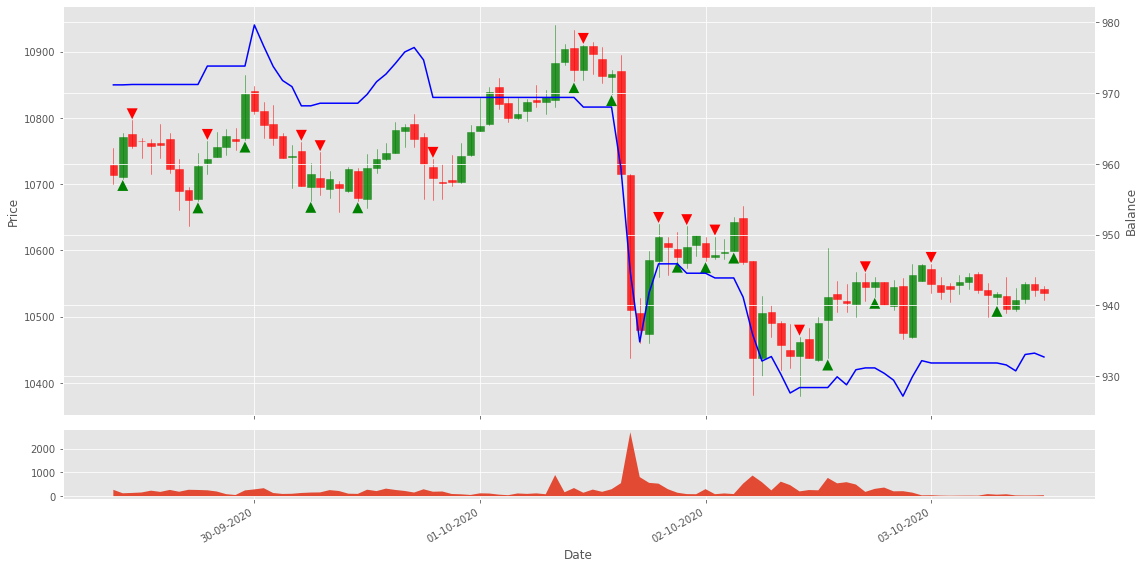

In [6]:
url = "https://raw.githubusercontent.com/decoderkurt/RL-Bitcoin-trading-bot/main/RL-Bitcoin-trading-bot_2/pricedata.csv"
df = pd.read_csv(url)
df = df.sort_values('Date')

lookback_window_size = 50
train_df = df[:-720-lookback_window_size]
test_df = df[-720-lookback_window_size:] # 30 days

train_env = CustomEnv(train_df, lookback_window_size=lookback_window_size)
test_env = CustomEnv(test_df, lookback_window_size=lookback_window_size)

Random_games(test_env, visualize=True, train_episodes = 1, training_batch_size=300)

In [8]:
!pip install imageio

In [9]:
import numpy as np
from PIL import Image
import os
import imageio

images = []
path_dir = 'images/'
file_list = os.listdir(path_dir)

for png in file_list:
    image = Image.open(path_dir + png)
    pixel = np.array(image)
    images.append(pixel)
  
imageio.mimsave('./result.gif', images, fps=1)